In [1]:
import pandas as pd 
import numpy as np
pd.options.display.max_columns =100
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.ensemble import RandomForestRegressor

## Introduction

Airbnb is an American online marketplace company based in San Francisco, California, United States. Airbnb offers arrangement for lodging, primarily homestays, or tourism experiences.It allows home-owners and renters ('hosts') to put their properties ('listings') online, so that guests can pay to stay in them. Hosts are expected to set their own prices for their listings. 

In this project I aim to predict the  price of the listings using machine learning models and implementing feature engineering to predict as accurate as possible. Airbnb pricing is important to get right, particularly in big cities like Netherlands where there is lots of competition and even small differences in prices can make the difference between optimum occupancy and high earnings, or being priced out of the market.

In [1]:
#Reading the data
df=pd.read_csv("listings.csv.gz")

In [92]:
print("Shape of Airbnb loaded: ",df.shape)

Shape of Airbnb loaded:  (20677, 106)


In [3]:
df.head(3)

id                         listing_url       scrape_id last_scraped  \
0   2818   https://www.airbnb.com/rooms/2818  20190808195507   2019-08-09   
1  20168  https://www.airbnb.com/rooms/20168  20190808195507   2019-08-09   
2  25428  https://www.airbnb.com/rooms/25428  20190808195507   2019-08-09   

                                              name  \
0         Quiet Garden View Room & Super Fast WiFi   
1     Studio with private bathroom in the centre 1   
2  Lovely apt in City Centre (w.lift) near Jordaan   

                                             summary  \
0           Quiet Garden View Room & Super Fast WiFi   
1  Cozy studio on your own private floor, 100% in...   
2                                                NaN   

                                               space  \
0  I'm renting a bedroom (room overlooking the ga...   
1  For those who like all facets of city life. In...   
2  This nicely furnished, newly renovated apt  is...   

                                         description experiences_offered  \
0  Quiet Garden View Room & Super Fast WiFi I'm r...                none   
1  Cozy studio on your own private floor, 100% in...                none   
2  This nicely furnished, newly renovated apt  is...                none   

                               neighborhood_overview  \
0  Indische Buurt ("Indies Neighborhood") is a ne...   
1  Located just in between famous central canals....   
2                                                NaN   

                                               notes  \
0  From week 38 to week 47 maintenance work to th...   
1  Check-in time from 2pm till 10pm (But it doesn...   
2                                                NaN   

                                             transit  \
0  The neighbourhood is well served by 24 hours p...   
1  No need to use any transport! All is within a ...   
2  The number 17 and #13 tram stop right outside ...   

                                              access  \
0                                                NaN   
1                                                NaN   
2  The apartment is about 75 meters or 800 square...   

                                         interaction  \
0                                                NaN   
1  No curfew, free entrance 27/7 with your own ke...   
2  However, our good friends who live close by ta...   

                                         house_rules  thumbnail_url  \
0  Please: - Leave your shoes in the entrance  - ...            NaN   
1  This studio/room takes entire floor and has it...            NaN   
2  The building is a quiet building, so please do...            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/10272854/8...   
1         NaN  https://a0.muscache.com/im/pictures/69979664/3...   
2         NaN  https://a0.muscache.com/im/pictures/138431/707...   

   xl_picture_url  host_id                                 host_url  \
0             NaN     3159   https://www.airbnb.com/users/show/3159   
1             NaN    59484  https://www.airbnb.com/users/show/59484   
2             NaN    56142  https://www.airbnb.com/users/show/56142   

   host_name  host_since                              host_location  \
0     Daniel  2008-09-24  Amsterdam, Noord-Holland, The Netherlands   
1  Alexander  2009-12-02  Amsterdam, Noord-Holland, The Netherlands   
2       Joan  2009-11-20          New York, New York, United States   

                                          host_about host_response_time  \
0  Upon arriving in Amsterdam, one can imagine as...     within an hour   
1  Secondary phone nr. + (Phone number hidden by ...     within an hour   
2  We are a retired couple who live in NYC, and h...     within an hour   

  host_response_rate  host_acceptance_rate host_is_superhost  \
0               100%                   NaN                 t   
1               100%                   NaN 

Checking the distribution of price variable 

In [4]:
df['price']=df['price'].str[1:-3]
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype(int)

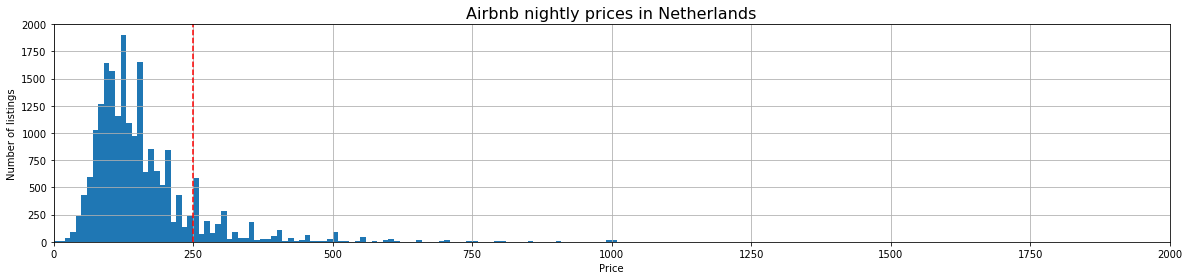

In [5]:
plt.figure(figsize=(20,4))
df.price.hist(bins=200, range=(0,2000))
plt.margins(x=0)
plt.axvline(250, color='red', linestyle='--')
plt.title("Airbnb nightly prices in Netherlands", fontsize=16)
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

In [6]:
outliers=df[df['price']>2000]
outliers['price']

122      8000
2917     4500
3640     8915
5997     2500
9105     3142
11689    2500
11798    5000
16709    3000
17201    6500
17245    5040
18789    7550
Name: price, dtype: int64

Price variable has outliers above 500$ but I will keep observations between 0 to 2000 dollars. 
I will remove  the outliers(11 observations) so as to generalize the model well.

In [7]:
df=df[df['price']<=2000]

In [8]:
df.shape

(20666, 106)

### Feature Engineering

#### dropping columns containing textual information as no NLP will be performed

In [9]:
cols_to_drop = ['id','listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 
                'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 
                'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 
                'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 
                'calendar_last_scraped','jurisdiction_names','amenities','calendar_updated']
df =df.drop(cols_to_drop, axis=1)

In [10]:
# dropping columns having more than 80% null values
missing_df=df.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['column_name', 'count']
missing_df['ratio']=missing_df['count']/20677
missing_df.sort_values(by='ratio',ascending=False,inplace=True)
missing_df.head(10)

column_name  count     ratio
5           host_acceptance_rate  20666  0.999468
14  neighbourhood_group_cleansed  20666  0.999468
65                       license  20641  0.998259
32                   square_feet  20280  0.980800
35                 monthly_price  19260  0.931470
34                  weekly_price  18077  0.874256
3             host_response_time   8535  0.412777
4             host_response_rate   8535  0.412777
36              security_deposit   6198  0.299753
37                  cleaning_fee   3718  0.179813

In [11]:
null_cols=['neighbourhood_group_cleansed','host_acceptance_rate','license','square_feet','monthly_price','weekly_price']
df.drop(null_cols,axis=1,inplace=True)

In [12]:
df['country'].unique()

array(['Netherlands'], dtype=object)

Since the data belongs to netherlands columns relating to city,country can be deleted. Only neighbourhood_cleansed will be kept as it contains information on the boroughs. Lattitude and longitude will be dropped later as they will be used for EDA

In [13]:
df.drop(['zipcode','street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 
         'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

Just keeping the minimum and maximum nights columns and dropping the below columns as they will be highly collinear and these variables presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.


In [14]:
df.drop(['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
        'maximum_nights_avg_ntm'],axis=1,inplace=True)

Dropping host_total_listings_count as majority of the values are same as host_listings_count and other calculated hosted listings 
are not very imporatnt hence can be dropped

In [15]:
sum((df.host_listings_count == df.host_total_listings_count) == False)

12

In [16]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

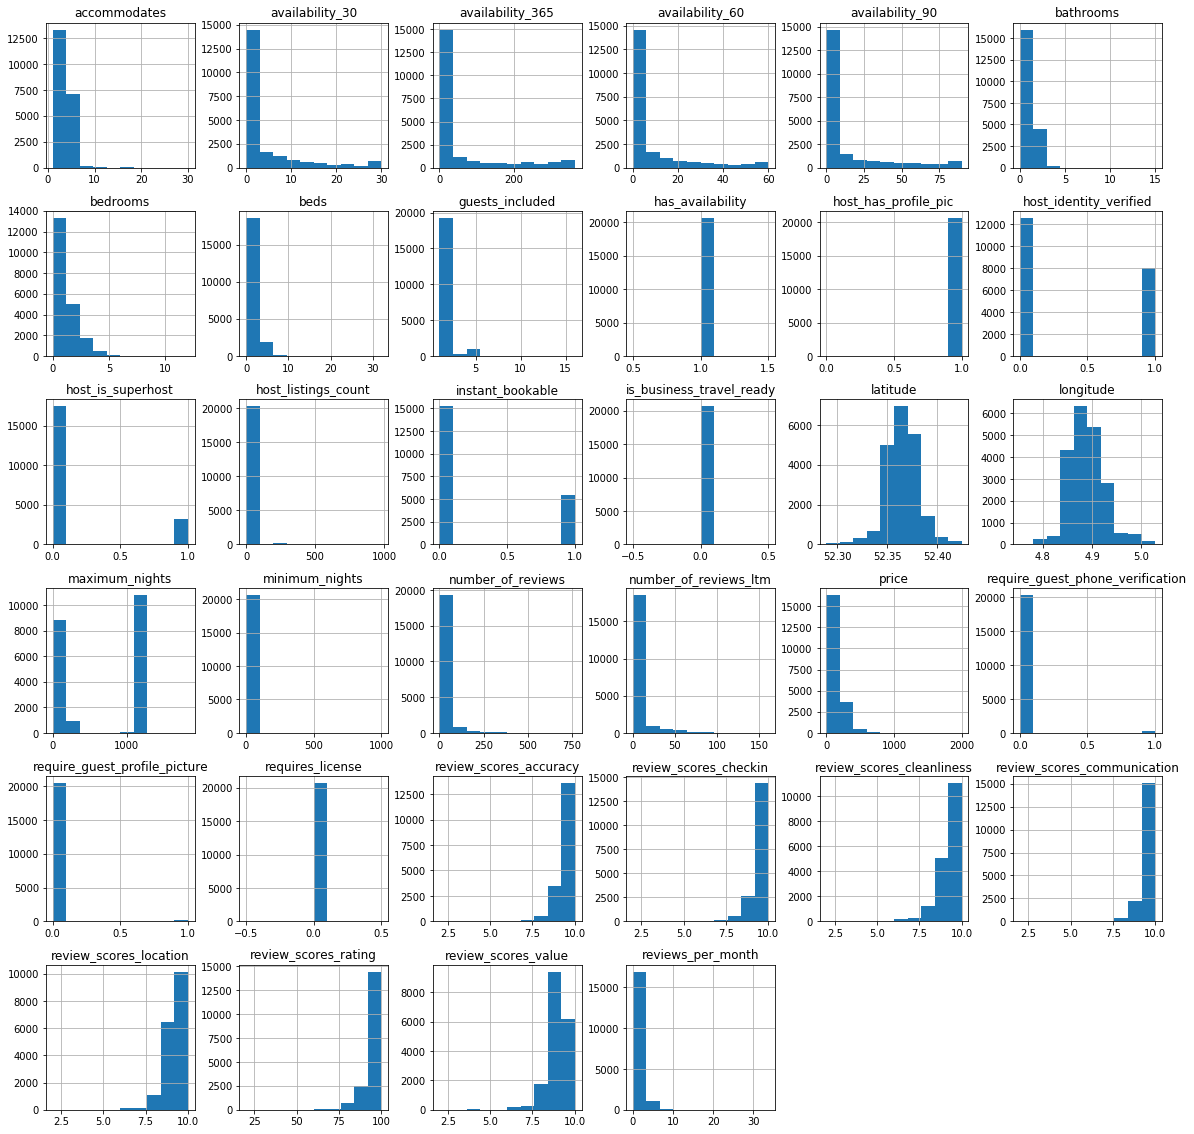

In [17]:
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize= (20,20)) ;

Columns that have only one values will be dropped as they provide no information


In [18]:
df.drop(['has_availability','is_business_travel_ready','host_has_profile_pic','require_guest_phone_verification',
        'require_guest_profile_picture','requires_license'], axis=1, inplace=True)

### Experience_offered

Experiences offered column has only None values hence I will drop this column

In [19]:
df.experiences_offered.value_counts()

none    20666
Name: experiences_offered, dtype: int64

In [20]:
df.drop('experiences_offered', axis=1, inplace=True)

### Host_since

Since host_since date values do not give any information I am going to change it number of days from host_since to the day when the data was scraped that is last_scraped column

In [21]:
df.host_since = pd.to_datetime(df.host_since) 
df.last_scraped=pd.to_datetime(df.last_scraped) 
# Calculating the number of days
df['host_since_days'] = (df['last_scraped']-df['host_since']).astype('timedelta64[D]')

# # Printing mean and median
print("Mean days as host:", round(df['host_since_days'].mean(),0))
print("Median days as host:", df['host_since_days'].median())

Mean days as host: 1613.0
Median days as host: 1650.0


### host_response_time

In [22]:
df.host_response_time.unique()

array(['within an hour', nan, 'within a day', 'a few days or more',
       'within a few hours'], dtype=object)

In [23]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 8535
Proportion: 41.3%


Filling null response rate with unknow category

In [24]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.412997
within an hour        0.300687
within a few hours    0.145940
within a day          0.124262
a few days or more    0.016113
Name: host_response_time, dtype: float64

#### Host_response_rate

In [25]:
df['host_response_rate'].isnull().sum()

8535

removing % sign and replacing null values with mean

In [26]:
df['host_response_rate']=df['host_response_rate'].str[:-1]
df['host_response_rate']=df['host_response_rate'].astype(str).astype(float)
df['host_response_rate']=df['host_response_rate'].fillna(round(df['host_response_rate'].mean(),0))
print("Mean days as host:", round(df['host_response_rate'].mean(),0))

Mean days as host: 94.0


### property_type

In [27]:
df.property_type.value_counts()

Apartment                 15824
House                      1640
Townhouse                   671
Bed and breakfast           548
Loft                        392
Boat                        351
Condominium                 334
Houseboat                   290
Guest suite                 146
Aparthotel                  119
Serviced apartment           69
Guesthouse                   49
Boutique hotel               43
Other                        39
Villa                        39
Hostel                       29
Hotel                        23
Tiny house                   12
Cottage                      12
Cabin                        10
Camper/RV                     5
Casa particular (Cuba)        3
Chalet                        3
Bungalow                      3
Barn                          2
Yurt                          2
Hut                           1
Campsite                      1
Tent                          1
Dome house                    1
Earth house                   1
Nature l

Grouping property_type into apartment, house and others as there are many categories.

In [28]:
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [29]:
df.property_type.value_counts()

Apartment    16285
House         2381
Other         2000
Name: property_type, dtype: int64

### bathrooms, bedrooms and beds

Replacing null with median values so as to avoid decimals


In [30]:
df[['bathrooms', 'bedrooms', 'beds']].isnull().sum()

bathrooms    6
bedrooms     8
beds         8
dtype: int64

In [31]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

### bed_type

In [32]:
df.bed_type.value_counts()


Real Bed         20487
Pull-out Sofa      119
Futon               40
Airbed              14
Couch                6
Name: bed_type, dtype: int64

Most listings have same bed_type so i will drop the bed_type column


In [33]:
df.drop('bed_type', axis=1, inplace=True)

### Price, Security deposit, cleaning_fee and extra people

Formatting price, security_deposit, extra_people, cleaning fee columns to remove $ and converting them into integer values.
Security_deposit, extra_people, cleaning fee have lot of null values which could possibly mean having 0 security deposit, cleaning fee or no charge for extra people. Replacing null values with 0 in these three columns


In [34]:
df[['price','security_deposit','extra_people','cleaning_fee']].isnull().sum()

price                  0
security_deposit    6198
extra_people           0
cleaning_fee        3718
dtype: int64

In [35]:
df[['price','security_deposit','extra_people','cleaning_fee']].head()

price security_deposit extra_people cleaning_fee
0     59          $200.00       $20.00       $60.00
1     80              NaN        $0.00          NaN
2    125          $300.00       $10.00       $40.00
3    150            $0.00        $0.00        $0.00
4     75              NaN        $0.00          NaN

In [36]:
def formatting(cols):
    for col in cols:
        df[col]=df[col].str[1:-3]
        df[col]=df[col].str.replace(',','')
        df[col]=df[col].astype(float)
        df[col].fillna(round(df[col].mean(),0),inplace=True)

In [37]:
formatting(cols=['security_deposit','extra_people','cleaning_fee'])

## availability

Just keeping availablity for 90 days as all other will be highly correlated with each other

In [38]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)


### Reviews

In [39]:
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
df[variables_to_plot].head()

review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  98.0                    10.0                       10.0   
1                  88.0                     9.0                       10.0   
2                 100.0                    10.0                       10.0   
3                  99.0                    10.0                       10.0   
4                  97.0                    10.0                       10.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                   10.0                         10.0                    10.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  
0                 10.0  
1                  9.0  
2                 10.0  
3                 10.0  
4                 10.0

In [40]:
df[variables_to_plot].isnull().sum()

review_scores_rating           2810
review_scores_accuracy         2821
review_scores_cleanliness      2819
review_scores_checkin          2831
review_scores_communication    2824
review_scores_location         2829
review_scores_value            2829
dtype: int64

In [41]:
for col in variables_to_plot:
    df[col]=df[col].fillna(round(df[col].mean(),0))


### Cancellation_policy

In [42]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    8002
moderate                       7488
flexible                       5037
super_strict_60                 112
super_strict_30                  26
Name: cancellation_policy, dtype: int64

### Number of reviews

In [43]:
print('Null values :',df['reviews_per_month'].isnull().sum() )
df['reviews_per_month']=df['reviews_per_month'].fillna(round(df['reviews_per_month'],1).mean())

Null values : 2587


dropping first and last review as these are in date forms and number_of_reviews_ltm refers to reviews in the last twelve months will be collinear with reviews per month

In [44]:
df.drop(['number_of_reviews_ltm','first_review','last_review'], axis=1, inplace=True)

# Exploratory Data Analysis

List of the largest host_listings_count and the year the host joined Airbnb


In [45]:
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
11557 2015-10-16                 99.0
5185  2011-12-02                115.0
18381 2018-07-12                131.0
15826 2012-07-07                139.0
12414 2016-04-05                217.0
14813 2016-06-06                435.0
12544 2014-08-12                486.0
20651 2018-03-12                739.0
14445 2017-03-22                980.0
20402        NaT                  NaN

### Top 10 Number of listings per neighborhood

The highest number of listings are in De Baarsjes - Oud-West

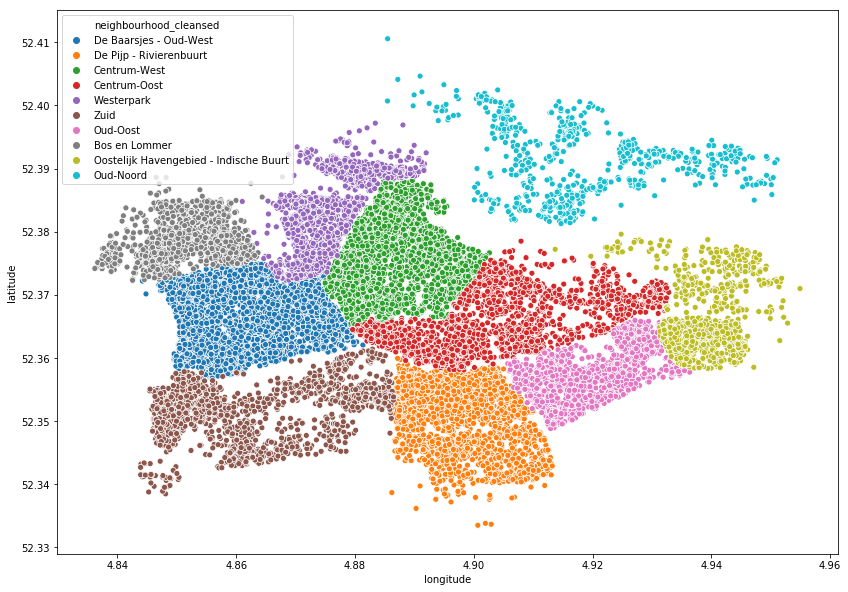

In [46]:
neighborhood=df['neighbourhood_cleansed'].value_counts().nlargest(10).reset_index()
neighborhood['index'].values.tolist()
top_10=df.set_index('neighbourhood_cleansed')
top_10=top_10.loc[['De Baarsjes - Oud-West','De Pijp - Rivierenbuurt','Centrum-West','Centrum-Oost',
 'Westerpark','Zuid','Oud-Oost','Bos en Lommer','Oostelijk Havengebied - Indische Buurt','Oud-Noord']]
top_10.reset_index(inplace=True)
plt.figure(figsize=(14,10))
sns.scatterplot(top_10.longitude,top_10.latitude,hue=top_10.neighbourhood_cleansed)
plt.ioff()

### Mean price of airbnb in different neighborhoods- Interactive plot

Centrum-Oost and Centrum West both have the highest per night mean price values 

In [47]:
ts=df.groupby(['neighbourhood_cleansed'])['price'].mean().reset_index()
fig = px.bar(ts, x="neighbourhood_cleansed", y="price", title='Mean price values of Neighborhoods',hover_name='neighbourhood_cleansed')
fig.update_layout(xaxis_type='category')
fig.show()

### Categorical Features

This section compares the proportions of categorical features that are true or false (to explore the data and relationship between the category and price).

In [48]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['purple', 'orange'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.mean().plot(kind='bar', ax=ax2, color=['purple', 'orange'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Mean price (£)')
    ax2.set_xlabel('')
    
    plt.show()

about 15% of hosts are superhosts. However, it does not seem to have effect on  the mean price per night of their Airbnb listings.

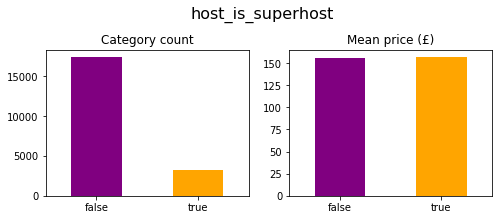

0.0    0.844485
1.0    0.155515
Name: host_is_superhost, dtype: float64


In [49]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

Around 39% of hosts are verified however  there is no discernable difference between the median nightly prices of listings with verified and unverified hosts.

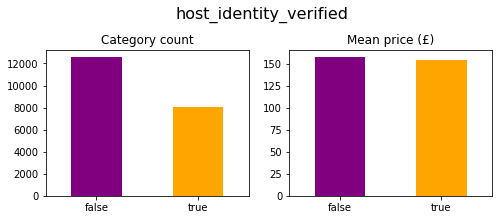

0.0    0.609712
1.0    0.390288
Name: host_identity_verified, dtype: float64


In [50]:
binary_count_and_price_plot('host_identity_verified')
print(df.host_identity_verified.value_counts(normalize=True))

Only about 26% of properties are instant bookable. However, the added convenience does not seem to have any effect on the mean price per night.

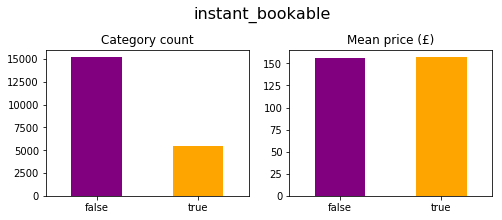

0    0.736379
1    0.263621
Name: instant_bookable, dtype: float64


In [51]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

In [52]:
def category_count_plot(col, figsize=(8,4)):
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

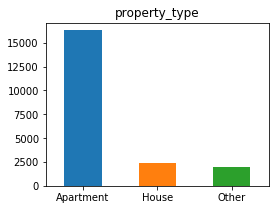

Apartment    0.788009
House        0.115213
Other        0.096777
Name: property_type, dtype: float64


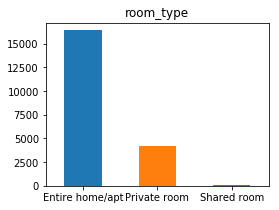

Entire home/apt    0.793235
Private room       0.202845
Shared room        0.003919
Name: room_type, dtype: float64


In [53]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

Time series plot of hosts joining Airbnb

In [54]:
df.host_since = pd.to_datetime(df.host_since) 
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)

In [55]:
ts_host_since.reset_index().head()

month  hosts
0 2008-09-01      1
1 2008-10-01      1
2 2008-11-01      0
3 2008-12-01      0
4 2009-01-01      1

In [56]:
def decompose_time_series(df, title=''):
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

Number of hosts joining Airbnb has decreased in the last few years

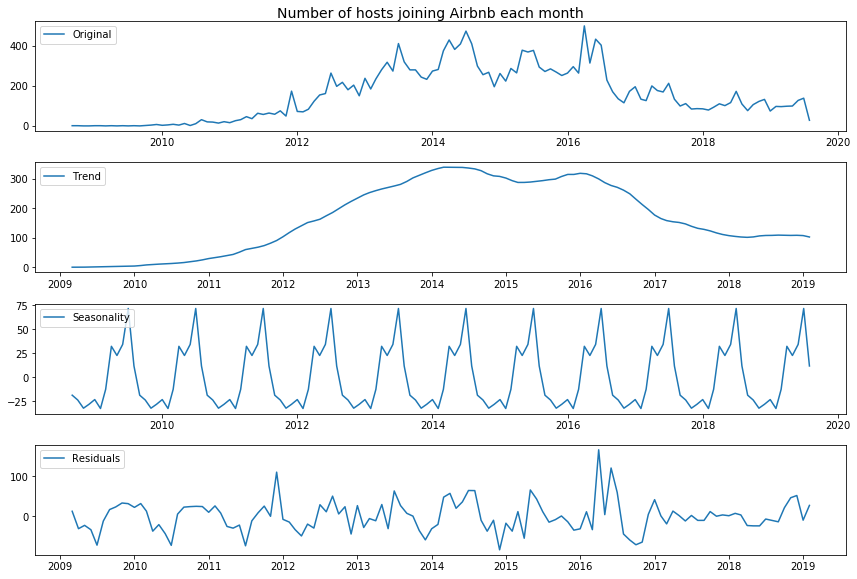

In [57]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')


## Reviews distribution

Majority of the listings have review scores in the range of 10 for all categories

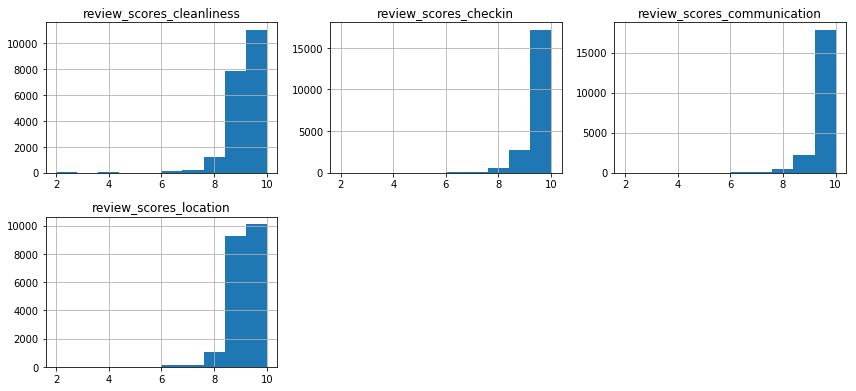

In [58]:
variables_to_plot=['review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [59]:
#Dropping variables that will not be used for predicting price 
df.drop(['host_since','last_scraped','latitude','longitude'],axis=1,inplace=True)

### Preparing the data for modeling

Performing one hot encoding for categorical variables

In [60]:
transformed_df = pd.get_dummies(df)

In [61]:
transformed_df.head()

host_response_rate  host_is_superhost  host_listings_count  \
0               100.0                1.0                  1.0   
1               100.0                0.0                  2.0   
2               100.0                0.0                  2.0   
3               100.0                1.0                  1.0   
4               100.0                1.0                  3.0   

   host_identity_verified  accommodates  bathrooms  bedrooms  beds  price  \
0                     0.0             2        1.5       1.0   2.0     59   
1                     0.0             2        1.0       1.0   1.0     80   
2                     0.0             3        1.0       1.0   1.0    125   
3                     1.0             2        1.0       1.0   1.0    150   
4                     1.0             2        1.0       1.0   1.0     75   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0             200.0          60.0                1          20.0   
1             225.0          40.0                2           0.0   
2             300.0          40.0                2          10.0   
3               0.0           0.0                1           0.0   
4             225.0          40.0                1           0.0   

   minimum_nights  maximum_nights  availability_90  number_of_reviews  \
0               3              15               43                267   
1               1            1000               34                283   
2              14              60               16                  3   
3               2             730               26                195   
4               2            1825               12                283   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  98.0                    10.0                       10.0   
1                  88.0                     9.0                       10.0   
2                 100.0                    10.0                       10.0   
3                  99.0                    10.0                       10.0   
4                  97.0                    10.0                       10.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                   10.0                         10.0                    10.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  instant_bookable  reviews_per_month  host_since_days  \
0                 10.0                 1               2.12           3971.0   
1                  9.0                 0               2.46           3537.0   
2                 10.0                 0               0.16           3549.0   
3                 10.0                 1               2.11           3426.0   
4                 10.0                 0               2.59           3375.0   

   host_response_time_a few days or more  host_response_time_unknown  \
0                                      0                           0   
1                                      0                           0   
2                                      0                           0   
3                                      0                           0   
4                                      0                           0   

   host_response_time_within a day  host_response_time_within a few hours  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0            

Checking for multi collinearity 

In [62]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

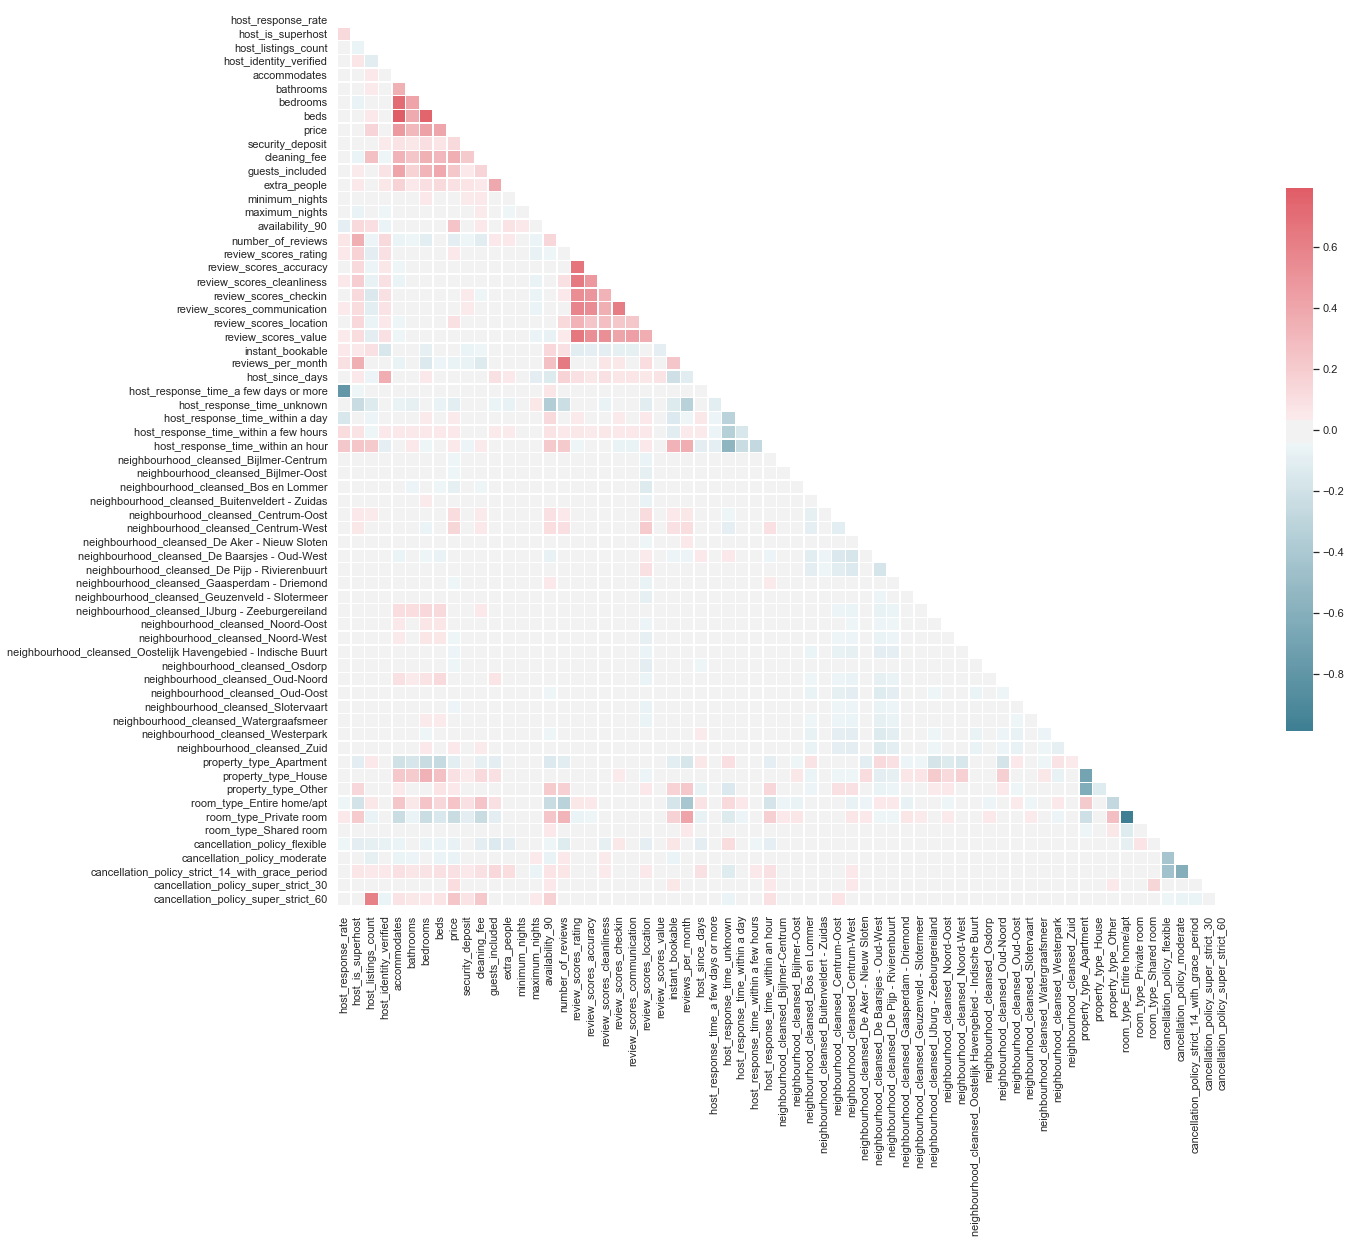

In [63]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))


In [64]:
#dropping highly multicollinear variables
transformed_df.drop(['beds','room_type_Private room','review_scores_rating','review_scores_value',
                    'reviews_per_month','cancellation_policy_super_strict_60',
                    'host_response_time_a few days or more','review_scores_checkin','review_scores_communication',
                    'cancellation_policy_strict_14_with_grace_period','property_type_Apartment'],axis=1,inplace=True)

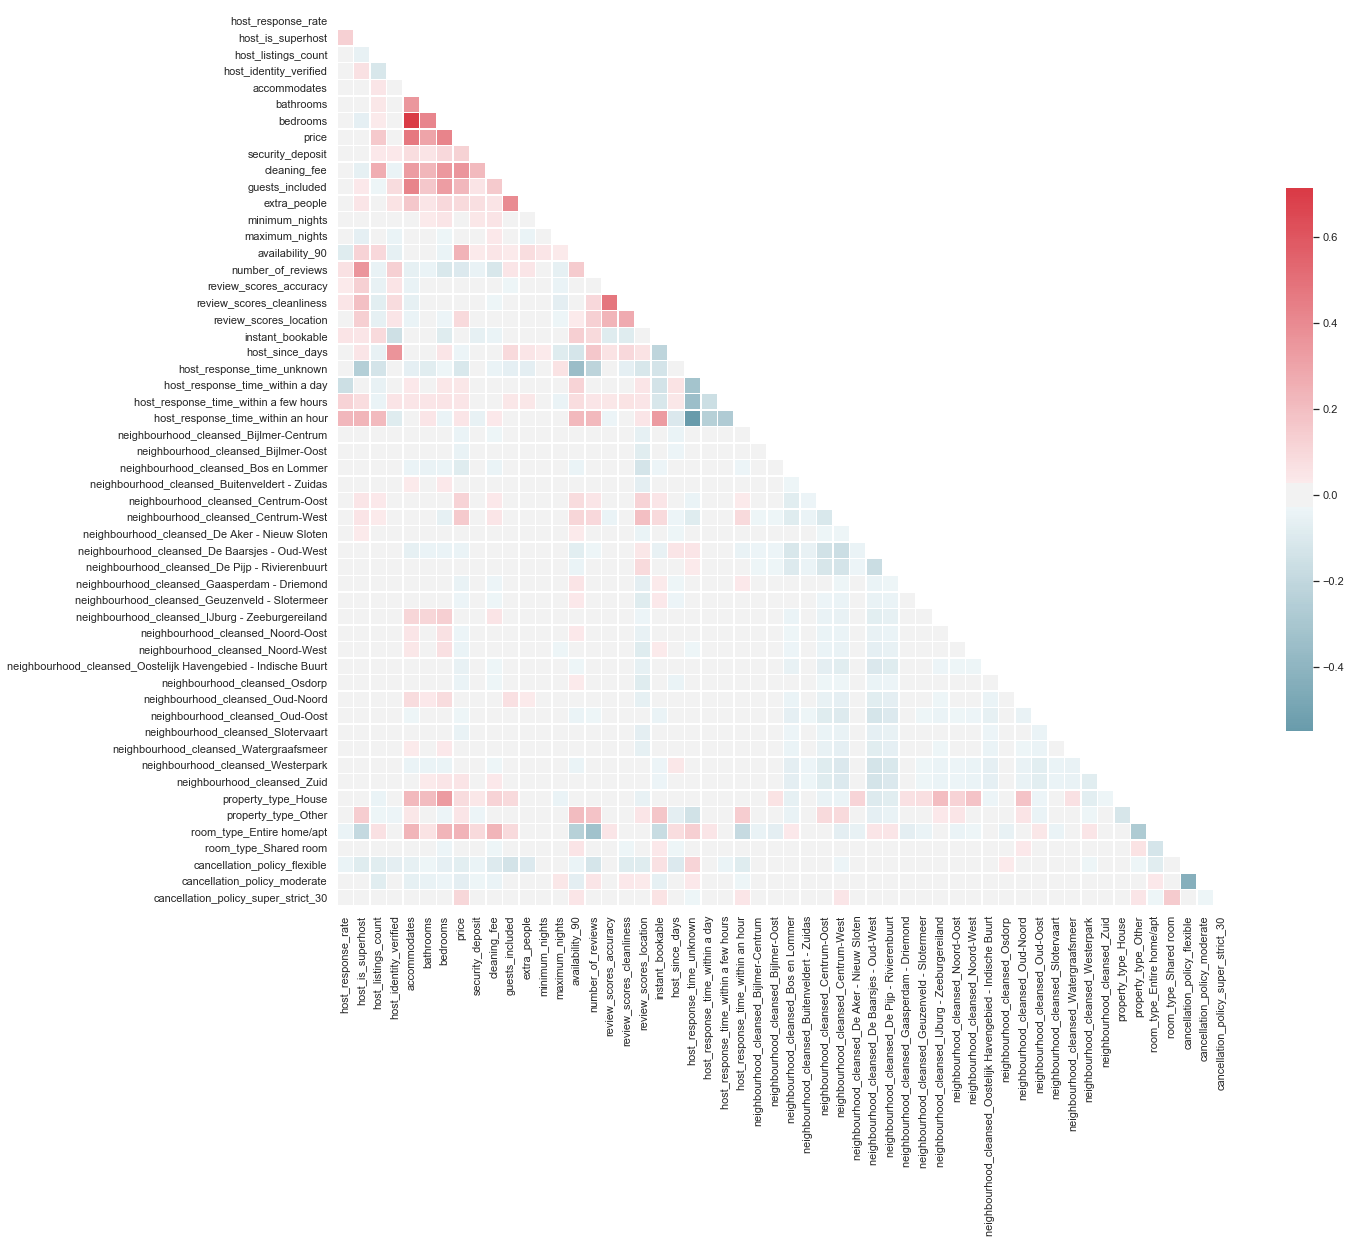

In [65]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))


In [66]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price',
                     'security_deposit','host_since_days']

In [67]:
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

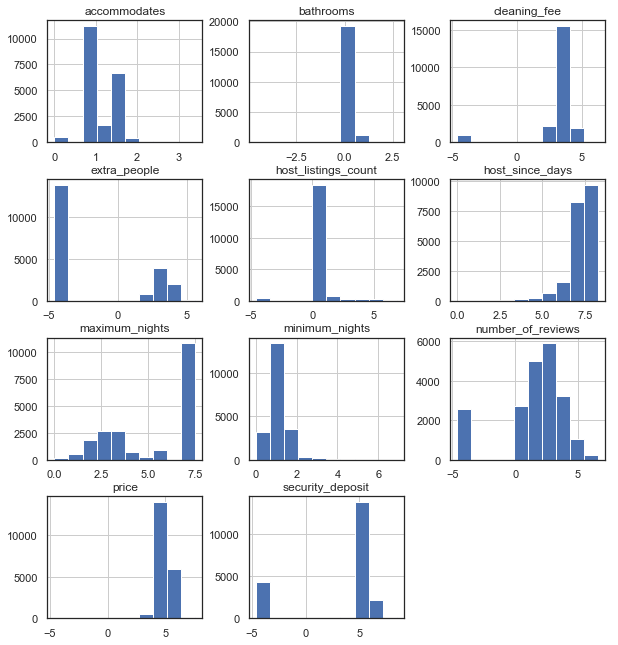

In [68]:
transformed_df[numerical_columns].hist(figsize=(10,11));


### Train-Test split

In [69]:
X = transformed_df.drop('price', axis=1)
y = transformed_df.price
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [71]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.058
Validation MSE: 0.1032

Training r2: 0.7818
Validation r2: 0.6054


In [72]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)


room_type entire home/apt, accomodates seem to have the highest importance in predicting price of the listings

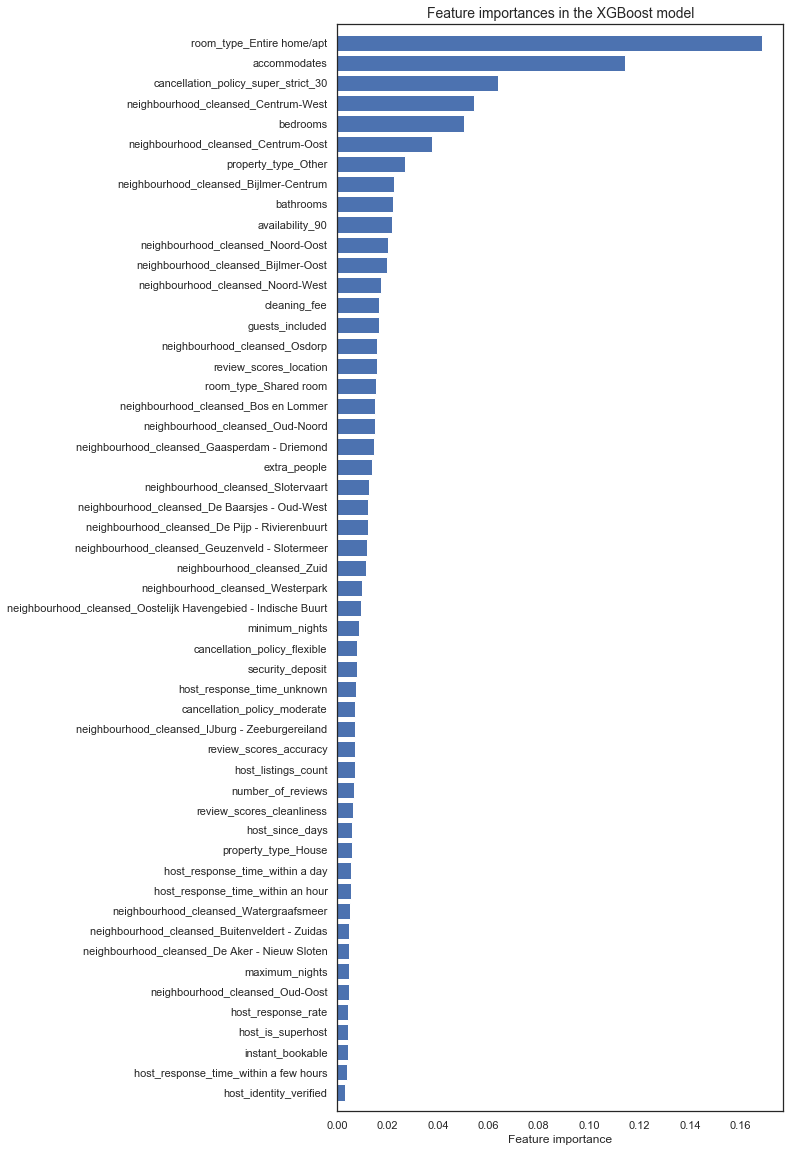

In [73]:
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Lets perform Randomsearch and see the scores

In [74]:
params={
 "learning_rate"    : [ 0.10,0.20, 0.25, 0.30, 0.35 ] ,
 "max_depth"        : [ 5, 10, 15, 20],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.2 , 0.3, 0.4,0.5,0.6 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
reg=xgboost.XGBRegressor()

In [89]:
random_search=RandomizedSearchCV(reg,param_distributions=params,n_iter=5,scoring='r2',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)
random_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   38.6s remaining:   49.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   53.2s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished


RandomForestRegressor(max_depth=15, n_estimators=1000)

In [76]:
regressor = random_search.best_estimator_

In [77]:
score=cross_val_score(regressor,X_train,y_train,cv=5,scoring='r2')

In [78]:
score.mean()

0.5818243768069375

In [79]:
regressor.fit(X_train,y_train)
predictions=regressor.predict(X_test)

In [80]:
print("test r2:", round(r2_score(y_test, predictions),4))
train_predict=regressor.predict(X_train)
print("\nTraining r2:", round(r2_score(y_train, train_predict),4))

test r2: 0.6304

Training r2: 0.8254


By hyper tuning the parameters using randomisedsearch the test and train score have increased significantly

# Random forest

In [81]:
transformed_df=transformed_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [82]:
X = transformed_df.drop('price', axis=1)
y = transformed_df.price
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [83]:
params={
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
  "n_estimators"    : [100,500,1000]   
}
reg=RandomForestRegressor()

In [84]:
random_search=RandomizedSearchCV(reg,param_distributions=params,n_iter=5,scoring='r2',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)
random_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   18.2s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   32.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.1s finished


RandomForestRegressor(max_depth=10, n_estimators=500)

In [85]:
regressor = random_search.best_estimator_
score=cross_val_score(regressor,X_train,y_train,cv=5)

In [86]:
score.mean()

0.5312814433069807

In [87]:
regressor.fit(X_train,y_train)
predictions=regressor.predict(X_test)

In [88]:
print("Test data r2:", round(r2_score(y_test, predictions),4))
train_predict=regressor.predict(X_train)
print("\nTraining data r2:", round(r2_score(y_train, train_predict),4))

test r2: 0.5704

Training r2: 0.659


### Model-selection 

As compared to Random forest XGBOOST performance using random search is the highest. This could be  further improved if  
more data is provided as model was trained only on 20,000 observations.

### Conclusions and recommendations


-The most important features in predicting price are room_type_entire_home/apt and accomodates. Having entire home/apt and more accomodates encourages guests to book and so can also be expected to have a significant impact on price
-Even in the best performing model, the model was only able to explain 63% of the variation in price. The rest of the variation is probably made up of features such as pictures of the houses, textual information such as amenities, reviews.The photos of properties on Airbnb are very important in encouraging guests to book.
-Getting more data will further improve model performance as it will have more observations to learn from. The model is trained on very few observations and is likely to overfit.